### Spherical Modelling

Calculate the completeness and purity of the galaxy population as a function of radius from the galaxy coordinate centre.

Requires the `periodic_kdtree` package, available [here](https://github.com/patvarilly/periodic_kdtree).

In [1]:
import pandas as pd
import numpy as np
import pickle as pcl

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

from palettable.tableau import GreenOrange_12
cmap = GreenOrange_12.hex_colors

from astropy.cosmology import Planck13

from periodic_kdtree import PeriodicCKDTree  # https://github.com/patvarilly/periodic_kdtree

from methods import normalise_coods
from methods import z_distort
from methods import factor_h
from methods import theoretical_ratios

h = 0.673
L = 480.279 / h

directory = '/lustre/scratch/astro/cl478/protoclusters_data/'
out_directory = 'output/'

First load the galaxy dataframes

In [2]:
redshifts = ['2p07','3p10','3p95','5p03','5p92','6p97','8p22','8p93','9p72']
zees = [float(z.replace('p','.')) for z in redshifts]

gals_sfr = [None] * len(redshifts)
gals_mstar = [None] * len(redshifts)

for i, (zed, z) in enumerate(zip(redshifts, zees)):
    print i, z
    
    gals_sfr[i] = pd.read_csv('%shenriques2015a_z%s_sfr_r200.csv'%(directory,zed), 
                              skiprows=122, skipfooter=1, engine='python')
    
    gals_mstar[i] = pd.read_csv('%shenriques2015a_z%s_stellarMass_r200.csv'%(directory,zed), 
                                skiprows=122, skipfooter=1, engine='python')
    
    gals_sfr[i] = factor_h(gals_sfr[i], h)
    gals_mstar[i] = factor_h(gals_mstar[i], h)
    

0 2.07
1 3.1
2 3.95
3 5.03
4 5.92
5 6.97
6 8.22
7 8.93
8 9.72


The `cluster_stats` function calculates the completeness, purity and overdensity as a function of radius from each protocluster in the `gals` dataframe provided. First define the radii range we wish to use:

In [3]:
radii = [float(x/2.) for x in range(100)[2:]]

In [4]:
def cluster_stats(gals, radii, L, redshift_distort=False, z=None):

    clusters = gals[gals['z0_central_mcrit200'] > 1.48e4].groupby('z0_centralId')['z0_central_mcrit200',
                        'z0_centralId'].max().reset_index(level=2, drop=True)

    cluster_stats = [None] * len(clusters)

    dimensions = np.array([L, L, L])
    
    if redshift_distort:
        gals = z_distort(gals, z, L)
        
        
    gal_coods = gals[['zn_x','zn_y','zn_z']].copy()
    
    avg_dgal = gals.shape[0] / L**3 * 4./3 * np.pi * np.array(radii)**3  # calculate average overdensity over R
        
    T = PeriodicCKDTree(dimensions, gal_coods)

    for i, cid in enumerate(clusters['z0_centralId']):  # loop over protoclusters
        
        coods = gal_coods[gals['z0_centralId'] == cid].as_matrix()  # protocluster galaxy coods
        no_pcs = coods.shape[0] # total number of protocluster galaxies
        coods = normalise_coods(coods, L)  # normalise protocluster galaxy coods
        center = np.median(coods, axis=0)  # find protocluster center
        pc_gal_distance = np.linalg.norm(coods-center, axis=1)  # distance of pc gals from centre
        
#        # take KDtree query out of radii loop (doesn't work for some reason..)
#         gal_index = T.query_ball_point(center, r=np.max(radii) + 1)  # find all gals within max(R) of center
#         all_coods = gal_coods.ix[gal_index].as_matrix()  
#         all_coods = norm_coods(all_coods, L)
#         all_gal_distance = np.linalg.norm(all_coods-center, axis=1)  # distance of all gals from centre

        completeness = []
        purity = []
        dgal = []
        
        for R, a_d in zip(radii, avg_dgal):

            gal_index = T.query_ball_point(center, r=R)
            all_gals_in_R = len(gal_index)
#             all_gals_in_R = np.sum(all_gal_distance < R)
            
            pcs_in_R = float(np.sum(pc_gal_distance < R))
            completeness.append(pcs_in_R / no_pcs)

            dgal.append((all_gals_in_R - a_d) / a_d)

            if all_gals_in_R == 0:
                purity.append(1)
            else:
                purity.append(pcs_in_R / all_gals_in_R)


        cluster_stats[i] = np.array([completeness, purity, dgal])

    return {'cstats': np.array(cluster_stats), 'clusters': clusters}

In [5]:
# cstats_mstar = [cluster_stats(gals.copy(), radii, L, redshift_distort=True, z=z) for gals, z in zip(gals_mstar,zees)]

# cstats_mstar10 = [cluster_stats(gals.loc[gals['zn_stellarMass'] > 1].copy(), radii, L, redshift_distort=True, z=z) \
#                   for gals, z in zip(gals_mstar[:6],zees[:6])]  # No gals at high-z

# cstats_sfr5 = [cluster_stats(gals.loc[gals['zn_sfr'] > 5].copy(), radii, L, redshift_distort=True, z=z) \
#                for gals, z in zip(gals_sfr,zees)]

# cstats_sfr = [cluster_stats(gals.copy(), radii, L, redshift_distort=True, z=z) for gals, z in zip(gals_sfr,zees)]


# pcl.dump([cstats_mstar10, cstats_mstar, cstats_sfr5, cstats_sfr], open('data/clustering_stats_r200.p','w'))    
cstats_mstar10, cstats_mstar, cstats_sfr5, cstats_sfr = pcl.load(open('data/clustering_stats_r200.p','r'))

Calculate theoretical ratios

In [7]:
P, C, P_sphere, C_sphere = theoretical_ratios(radii=radii)
P_od, C_od, P_sphere_od, C_sphere_od = theoretical_ratios(radii=radii, overdensity=5)

Recalculate stats for no redshift distortion case

In [8]:
cstats = cluster_stats(gals_sfr[2].copy(), radii, L, redshift_distort=True, z=3.95)
cstats_no_distort = cluster_stats(gals_sfr[2].copy(), radii, L, redshift_distort=False)
z = '3.95'

Figure 4 from the paper

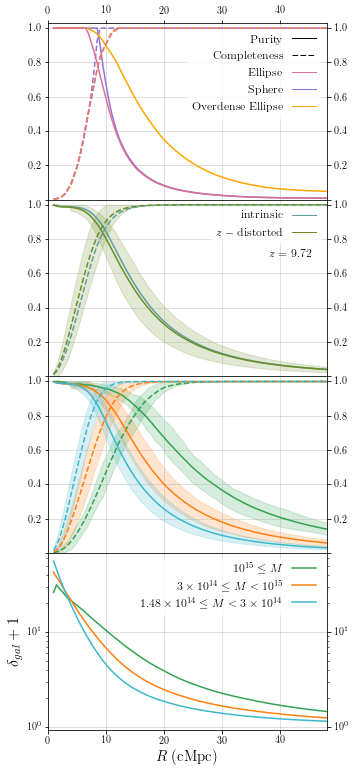

In [11]:
fig = plt.figure(figsize=(5,13))

gs = gridspec.GridSpec(4, 1)

gs.update(hspace=0, wspace=0) #bottom = 0.57, top = 1, 

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[2,0])
ax4 = fig.add_subplot(gs[3,0])

i = 0

## Plot 1
completeness = np.array([np.percentile(y, [84,16]) for y in np.vstack([x[0] for x in np.array(cstats['cstats'])]).T])
purity = np.array([np.percentile(y, [84,16]) for y in np.vstack([x[1] for x in np.array(cstats['cstats'])]).T])

# theoretical curves
ax1.plot(radii, C_sphere, label='C (sphere)', c='mediumpurple', linestyle='dashed')
ax1.plot(radii, P_sphere, label='P (sphere)', c='mediumpurple', linestyle='solid')

ax1.plot(radii, C_od, label='C (sphere)', c='orange', linestyle='dashed')
ax1.plot(radii, P_od, label='P (sphere)', c='orange', linestyle='solid')

ax1.plot(radii, C, label='C (ellipse)', c='palevioletred', linestyle='dashed')
ax1.plot(radii, P, label='P (ellipse)', c='palevioletred', linestyle='solid')

## plot 2

# no distort
c ='cadetblue'
ax2.plot(radii, np.mean([x[0] for x in np.array(cstats_no_distort['cstats'])], axis=0), c=c, linestyle='dashed')
ax2.plot(radii, np.mean([x[1] for x in np.array(cstats_no_distort['cstats'])], axis=0), c=c)

# completeness = np.array([np.percentile(y, [84,16]) for y in np.vstack([x[0] for x in np.array(cstats_no_distort['cstats'])]).T])
# purity = np.array([np.percentile(y, [84,16]) for y in np.vstack([x[1] for x in np.array(cstats_no_distort['cstats'])]).T])
# ax2.fill_between(rangex, completeness[:,0], completeness[:,1], alpha=0.2, color=c)
# ax2.fill_between(rangex, purity[:,0], purity[:,1], alpha=0.2, color=c)

# z distort
c ='olivedrab'

completeness = np.array([np.percentile(y, [84,16]) for y in np.vstack([x[0] for x in np.array(cstats['cstats'])]).T])
purity = np.array([np.percentile(y, [84,16]) for y in np.vstack([x[1] for x in np.array(cstats['cstats'])]).T])
ax2.fill_between(radii, completeness[:,0], completeness[:,1], alpha=0.2, color=c)
ax2.fill_between(radii, purity[:,0], purity[:,1], alpha=0.2, color=c)

ax2.plot(radii, np.mean([x[0] for x in np.array(cstats['cstats'])], axis=0), c=c, linestyle='dashed')
ax2.plot(radii, np.mean([x[1] for x in np.array(cstats['cstats'])], axis=0), c=c)


# intercepts = [np.mean([x[0] for x in np.array(cstats['cstats'])], axis=0)[np.where([x == r for x in rangex])][0] for r in [4,7,10]]
# ax2.vlines([4,7,10],0,intercepts, color=c, linewidth=1, linestyle='dashed')
# ax2.hlines(intercepts, [4,7,10],30, color=c, linewidth=1, linestyle='dashed')

# intercepts = [np.mean([x[1] for x in np.array(cstats['cstats'])], axis=0)[np.where([x == r for x in rangex])][0] for r in [4,7,10]]
# ax2.vlines([4,7,10],0,intercepts, color=c, linewidth=1, linestyle='solid')
# ax2.hlines(intercepts, [4,7,10], 0, color=c, linewidth=1, linestyle='solid')


# Plot 3 + 4
mask_A = np.array(cstats['clusters']['z0_central_mcrit200']) > 1e5
mask_B = (np.array(cstats['clusters']['z0_central_mcrit200']) > 3e4) & (np.array(cstats['clusters']['z0_central_mcrit200']) <= 1e5)
mask_C = (np.array(cstats['clusters']['z0_central_mcrit200']) > 1.48e4) & (np.array(cstats['clusters']['z0_central_mcrit200']) <= 3e4)
    
for i, mask in enumerate([mask_A, mask_B, mask_C]):
    
    ax4.semilogy(radii, np.nanmean([x[2] for x in np.array(cstats['cstats'])[mask]],axis=0) + 1,
                 c=cmap[i*2], ls='solid')
    
#     dgal_range = np.array([np.percentile(y, [84,16]) for y in np.vstack([x[2] for x in np.array(cstats['cstats'])[mask]]).T])
#     ax1.fill_between(rangex, dgal_range[:,0], dgal_range[:,1], alpha=0.2, color=cmap[i*2])
    
    completeness = np.array([np.percentile(y, [84,16]) for y in np.vstack([x[0] for x in np.array(cstats['cstats'])[mask]]).T])
    purity = np.array([np.percentile(y, [84,16]) for y in np.vstack([x[1] for x in np.array(cstats['cstats'])[mask]]).T])

    ax3.fill_between(radii, completeness[:,0], completeness[:,1], alpha=0.2, color=cmap[i*2])

    ax3.fill_between(radii, purity[:,0], purity[:,1], alpha=0.2, color=cmap[i*2])

    ax3.plot(radii, np.mean([x[0] for x in np.array(cstats['cstats'])[mask]], axis=0), 
             c=cmap[i*2], linestyle='dashed')
    
    ax3.plot(radii, np.mean([x[1] for x in np.array(cstats['cstats'])[mask]], axis=0), c=cmap[i*2])


ax4.set_xlabel('$R \;(\mathrm{cMpc})$', size=15)
ax4.set_ylabel('$\delta_{gal} + 1$', size=16)

ax1.xaxis.tick_top()

for ax in [ax1,ax2,ax3]:
    ax.set_yticklabels(['','$0.2$','$0.4$','$0.6$','$0.8$','$1.0$'])

ax2.set_xticklabels([])
ax3.set_xticklabels([])

for ax in [ax1, ax2, ax3]:
    ax.set_ylim(0, 1.03)
    

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(0, 48)
    ax.grid(alpha=0.5)
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(labelright=True)

line_z = []
for i in range(3):
    line_z.append(plt.Line2D((0,1),(0,0), color=cmap[i*2], linestyle='solid'))
    
legend4 = ax4.legend(handles=[line for line in line_z], 
                   labels=['$10^{15} \leq M$',
                           '$3 \\times 10^{14} \leq M < 10^{15}$',
                           '$1.48 \\times 10^{14} \leq M < 3 \\times 10^{14}$'],
                   prop={'size':12}, loc=1)

line_comp = plt.Line2D((0,1.5),(0,0), color='black', linestyle='solid', linewidth=1)
line_puri = plt.Line2D((0,1.5),(0,0), color='black', linestyle='dashed', linewidth=1)
line_theory_ell = plt.Line2D((0,1.5),(0,0), color='palevioletred', linestyle='solid', linewidth=1)
line_theory_sph = plt.Line2D((0,1.5),(0,0), color='mediumpurple', linestyle='solid', linewidth=1)
line_theory_ell_od = plt.Line2D((0,1.5),(0,0), color='orange', linestyle='solid', linewidth=1)

legend1 = ax1.legend(handles=[line_comp, line_puri, line_theory_ell, line_theory_sph, line_theory_ell_od], 
                   labels=['$\mathrm{Purity}$', '$\mathrm{Completeness}$','$\mathrm{Ellipse}$',
                           '$\mathrm{Sphere}$', '$\mathrm{Overdense \,\, Ellipse}$'],
                   prop={'size':12}, loc=1)


line_actual = plt.Line2D((0,1.5),(0,0), color='cadetblue', linestyle='solid', linewidth=1)
line_zdistort = plt.Line2D((0,1.5),(0,0), color='olivedrab', linestyle='solid', linewidth=1)

legend2 = ax2.legend(handles=[line_actual, line_zdistort],labels=['$\mathrm{intrinsic}$', '$z-\mathrm{distorted}$'],prop={'size':12}, loc=1)
ax2.text(38, 0.7, '$z = %s$'%z, size=12)

for legend in [legend1,legend2,legend4]:
    
    legend.get_frame().set_edgecolor('white')

    # right align
    vp = legend._legend_box._children[-1]._children[0] 
    for c in vp._children: 
        c._children.reverse() 
    vp.align="right" 


# plt.savefig(out_directory+"compur_masscomp_dgal.png", bbox_inches='tight', dpi=300)

Figure 5 from the paper

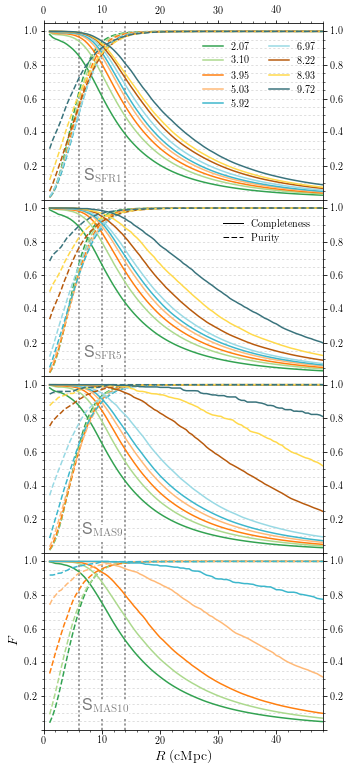

In [12]:
fig = plt.figure(figsize=(5,13))

gs = gridspec.GridSpec(4, 1)

gs.update(hspace=0, wspace=0) #bottom = 0.57, top = 1, 

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[2,0])
ax4 = fig.add_subplot(gs[3,0])

# redshifts = ['9.72','8.93','8.22','6.97','5.92','5.03','3.95','3.10','2.07']
redshifts = ['2.07','3.10','3.95','5.03','5.92','6.97','8.22','8.93','9.72']


#### Plot 1
for i, cstat in enumerate(cstats_sfr):

    ax1.plot(radii, np.mean([x[0] for x in cstat['cstats']], axis=0), c=cmap[i], linestyle='dashed')

    ax1.plot(radii, np.ma.masked_where([x[1] for x in cstat['cstats']] == 0, 
                   np.mean([x[1] for x in cstat['cstats']], axis=0)), c=cmap[i])


#### Plot 2
for i, cstat in enumerate(cstats_sfr5):

    ax2.plot(radii, np.mean([x[0] for x in cstat['cstats']], axis=0), c=cmap[i], linestyle='dashed')

    ax2.plot(radii, np.ma.masked_where([x[1] for x in cstat['cstats']]==0, 
                    [x[1] for x in cstat['cstats']]).mean(axis=0), cmap[i])


#### Plot 3
for i, (z, cstat) in enumerate(zip(redshifts, cstats_mstar)):
    
    ax3.plot(radii, np.mean([x[0] for x in cstat['cstats']], axis=0), c=cmap[i], linestyle='dashed')

    ax3.plot(radii, np.ma.masked_where([x[1] for x in cstat['cstats']] == 0, 
                    np.vstack([x[1] for x in cstat['cstats']])).mean(axis=0), c=cmap[i], label=z)

    
#### Plot 4
for i, cstat in enumerate(cstats_mstar10[:5]):

    ax4.plot(radii, np.mean([x[0] for x in cstat['cstats']], axis=0), c=cmap[i], linestyle='dashed')

    ax4.plot(radii, np.ma.masked_where([x[1] for x in cstat['cstats']]==0, 
                    [x[1] for x in cstat['cstats']]).mean(axis=0), cmap[i])

    
for ax in [ax1,ax2,ax3,ax4]:
    ## add vlines
    ax.vlines([6,10,14],0,1.05,color='grey',linestyle='dotted')
    
    ax.set_ylim(0,1.05)
    ax.set_xlim(0,48)
    
    ax.yaxis.grid(which='both', alpha=0.5, linestyle='dotted')
    ax.minorticks_on()
    
    ax.set_yticklabels(['','$0.2$','$0.4$','$0.6$','$0.8$','$1.0$'])
    
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(labelright=True)


ax1.xaxis.tick_top()
ax4.set_xlabel('$R \; (\mathrm{cMpc})$', size=14)
ax4.set_ylabel('$F$', size=14)

ax1.text(6.9, 0.1, "S$_{\mathrm{SFR1}}$", size=16, color='grey',bbox=dict(facecolor='white', edgecolor='white', pad=0.0))
ax2.text(6.9, 0.1, "S$_{\mathrm{SFR5}}$", size=16, color='grey',bbox=dict(facecolor='white', edgecolor='white', pad=0.0))
ax3.text(6.5, 0.1, "S$_{\mathrm{MAS9}}$", size=16, color='grey',bbox=dict(facecolor='white', edgecolor='white', pad=0.0))
ax4.text(6.5, 0.1, "S$_{\mathrm{MAS10}}$", size=16, color='grey',bbox=dict(facecolor='white', edgecolor='white', pad=0.0))

for ax in [ax2,ax3]:
    ax.set_xticklabels([])


line_z = []
for i in range(len(redshifts)):
    line_z.append(plt.Line2D((0,1),(0,0), color=cmap[i], linestyle='solid'))

    
line_comp = plt.Line2D((0,1.5),(0,0), color='black', linestyle='solid', linewidth=1)
line_puri = plt.Line2D((0,1.5),(0,0), color='black', linestyle='dashed', linewidth=1)

ax1.legend(handles=[line for line in line_z], 
               labels=['$%s$'%z for z in redshifts],
               prop={'size':10}, bbox_to_anchor=(0.54, 0.94), ncol=2, frameon=False)

ax2.legend(handles=[line_comp, line_puri], 
               labels=['$\mathrm{Completeness}$','$\mathrm{Purity}$'],
               prop={'size':10}, bbox_to_anchor=(0.61, 0.94), ncol=1, frameon=False)
    

# plt.savefig(out_directory+"compur.png", bbox_inches='tight', dpi=300)